In [9]:
import numpy as np
import random
from tqdm import trange
import matplotlib.pyplot as plt

In [10]:
def decode_strategy(stra: np.ndarray, mem: int) -> np.ndarray:
    return (stra >> mem) % 2

def encode_memory(mem: int, winner: int, M: int) -> int:
    return ((mem<<1)+winner)%(2**M)

In [11]:
N, M, K = 801, 3, 4
# N: number of players
# M: length of memory
# K: strategy space for each player

In [12]:
num_possible_mem = 2**M
num_possible_stra = 2**num_possible_mem

stra_total = np.arange(num_possible_stra)
stra_score = stra_total*0.0

# Represent players by their K strategy idxs
players = np.array(
    [np.random.choice(num_possible_stra,size=K,replace=False)
     for _ in range(N)]
)
print(f"some players:\n{players[:5]}")

mem = np.random.randint(num_possible_mem)
print(f"(init) mem = {mem}")

some players:
[[  9 204  49  81]
 [ 36  59 204  96]
 [147 228 144 165]
 [191   8  25 239]
 [120 203 222  31]]
(init) mem = 3


In [13]:
attnrec = []
gamerec = []
price = 1
t_simu = 5000

for t in trange(t_simu):
    # STEP 1: SIMULATE
    vpoints = stra_score[players]
    strategy = players[np.arange(N), np.argmax(vpoints, axis=1)]
    behavior = decode_strategy(strategy, mem)

    # STEP 2: MEASURE
    attendance = np.sum(behavior)           # BOOK p31
    excess_demand = np.sum(2*behavior-1)    # BOOK p65
    winner = 0 if excess_demand>0 else 1
    r = excess_demand/(0.5*N)               # BOOK p65

    # STEP 3: LEARN
    attn_diff = N-2*attendance
    reward = attn_diff/N                    # BOOK p32
    all_stra_response = decode_strategy(stra_total, mem)
    # stra_score += 1*(all_stra_response==winner)
    # stra_score += 2*(all_stra_response==winner)-1
    stra_score += 2*(all_stra_response-1)*reward

    # STEP 4: UPDATE
    mem = encode_memory(mem, winner, M)

    # STEP 5: RECORD

    attnrec.append(attendance)
    gamerec.append(1*(behavior==winner))
    # gamerec.append(2*(behavior==winner)-1)
    # gamerec.append(r*(2*behavior-1))

    # price *= (N+attn_diff)/(N-attn_diff)



100%|██████████| 5000/5000 [00:00<00:00, 14995.42it/s]


average attendance:
	400.4522


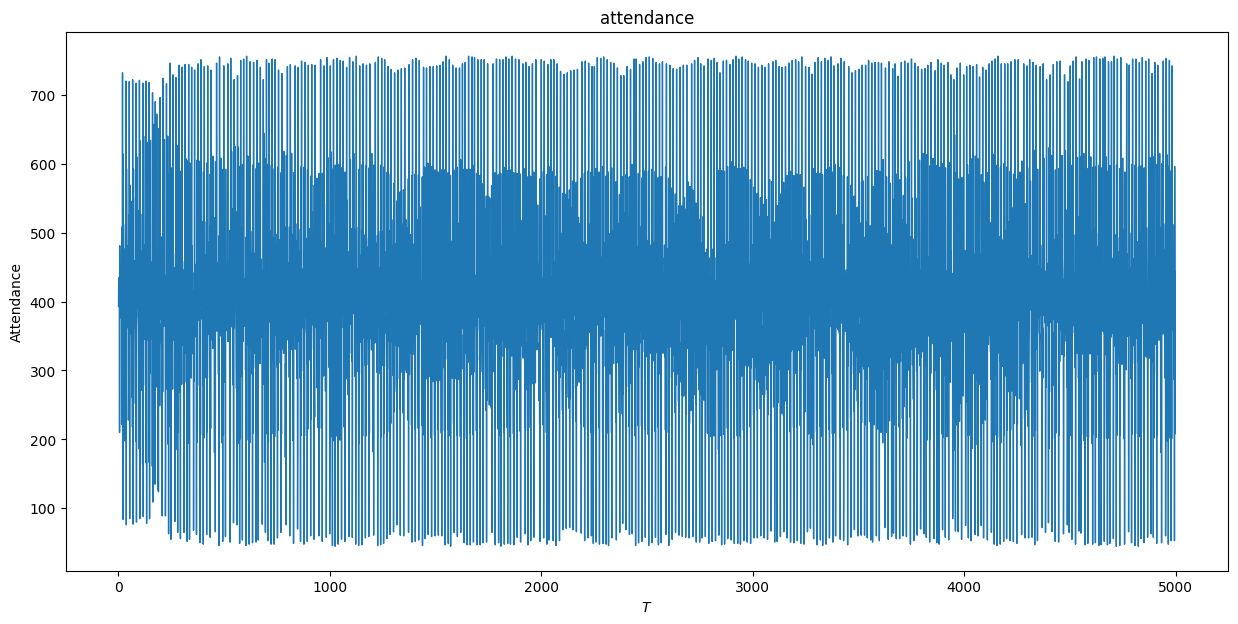

In [14]:
print(f"average attendance:\n\t{np.mean(attnrec)}")

plt.figure(figsize=(15, 7))
plt.plot(attnrec, lw=1.0)
plt.title('attendance')
plt.xlabel('$T$')
plt.ylabel('Attendance')
plt.show()

In [15]:
gamerec = np.array(gamerec)

performance = np.cumsum(np.array(gamerec), axis=0)*1.0
performance /= np.cumsum(np.ones_like(performance), axis=0)

final_round = performance[-1, :]
min_performance = np.argwhere(final_round==np.min(final_round))[0]
max_performance = np.argwhere(final_round==np.max(final_round))[0]
print(f"max wr\n\t{np.max(final_round)}")
print(f"min wr\n\t{np.min(final_round)}")


max wr
	0.4434
min wr
	0.291


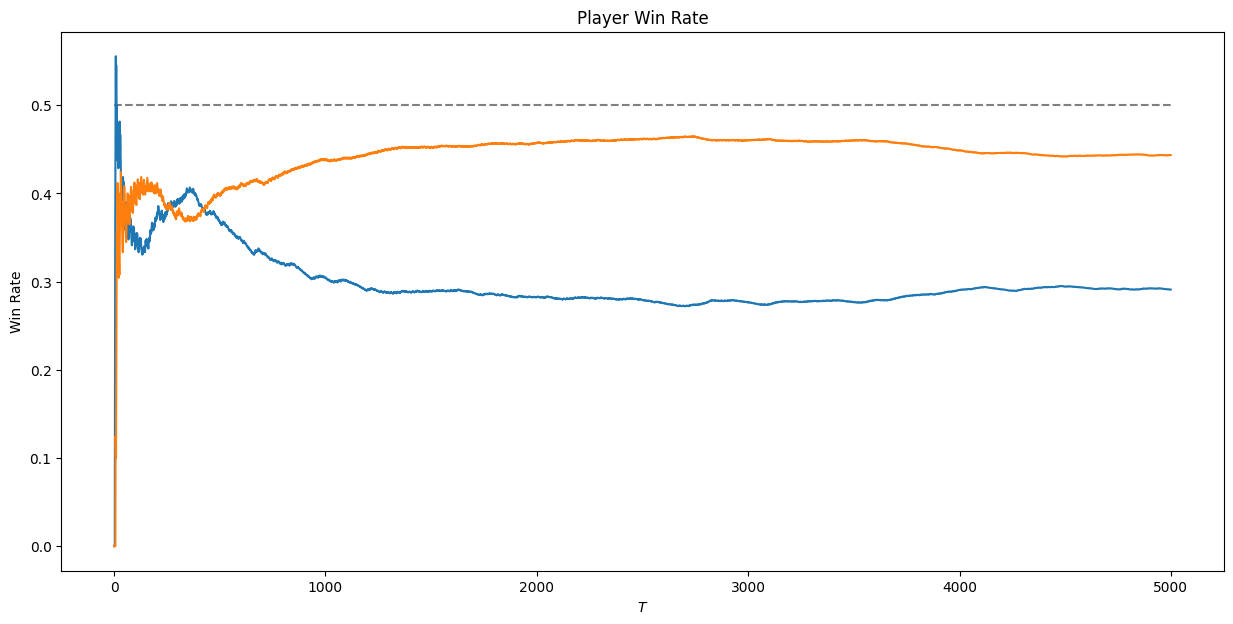

In [16]:
plt.figure(figsize=(15, 7))
plt.hlines(y=0.5, xmin=0, xmax=t_simu, linestyles='dashed', colors='gray')
plt.plot(performance[:, min_performance])
plt.plot(performance[:, max_performance])
plt.title('Player Win Rate')
plt.xlabel('$T$')
plt.ylabel('Win Rate')
plt.show()